In [8]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

from pathlib import Path
import os
import sys
sys.path.append(str(Path(os.getcwd()).parent / "src"))

In [10]:
from ngsolve.webgui import Draw
import utils
import double_fluid_gel_fem
import importlib

importlib.reload(double_fluid_gel_fem)
importlib.reload(utils)

<module 'utils' from '/Users/yuli/Documents/Code/Cleavage/src/utils.py'>

In [11]:
tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.06
right_edge = 0.5 + 0.06
left_transition = 0.5 * (tanh((x - left_edge)/0.01))
right_transition = 0.5 * (tanh((right_edge - x)/0.01))

bottom_transition = 0.5 * (tanh((y - 0.1)/0.1))
top_transition = 0.5 * (tanh((0.9 - y)/0.1))
source =1*(left_transition + right_transition) *(top_transition + bottom_transition)

def add_cbar(ax, im, vmin, vmax, label):
    cbar = plt.colorbar(im, ax=ax, location='bottom', pad=0.1)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([f'{vmin:.1g}', f'{vmax:.1g}'])
    cbar.set_label(label, fontsize=20)
    return cbar

In [64]:
T = 20
tau = 0.05
chi0 = 0.05
chi1 = 0.2
beta_prod = 1
beta2 = 1
beta1 = beta_prod/beta2
eta = 1
kappa = 1e-3
k_actin = 0.1

param_sets = [
    [0.1, 0.2], 
]

sim_results = [] 
for i, (chi0, chi1) in enumerate(param_sets):
    print(f"Running simulation {i+1} with chi0={chi0}, chi1={chi1}")

    sim = double_fluid_gel_fem.DoubleActinGel2D(
        width=1, height=1, maxh=0.03,
        gamma=eta, eta_1=eta, eta_2=0,
        k=1, k_actin=k_actin,
        D=1e-4, kappa=kappa,
        beta1=beta1, beta2=beta2,
        chi0=chi0, chi1=chi1,
        Qsq=-1+2*source,
        rho0=1*source,
        rho0_actin=1*(1-source))

    sim.density.Set(1*source)
    sim.density2.Set((1-source))

    sim.simulate(
        tend=T,
        tau=tau,
        save_interval=int(0.5/tau)  # save once a second
    )

    filename = f'sim_data/caRhoA_{i+1}'
    n_samples = 60
    data = sim.export_to_npy(filename, n_samples=n_samples)
    sim_results.append(data) 

Running simulation 1 with chi0=0.1, chi1=0.2


  5%|▍         | 19/400 [00:00<00:02, 182.30it/s]

craete bilinearformapplication


100%|██████████| 400/400 [00:02<00:00, 155.13it/s]


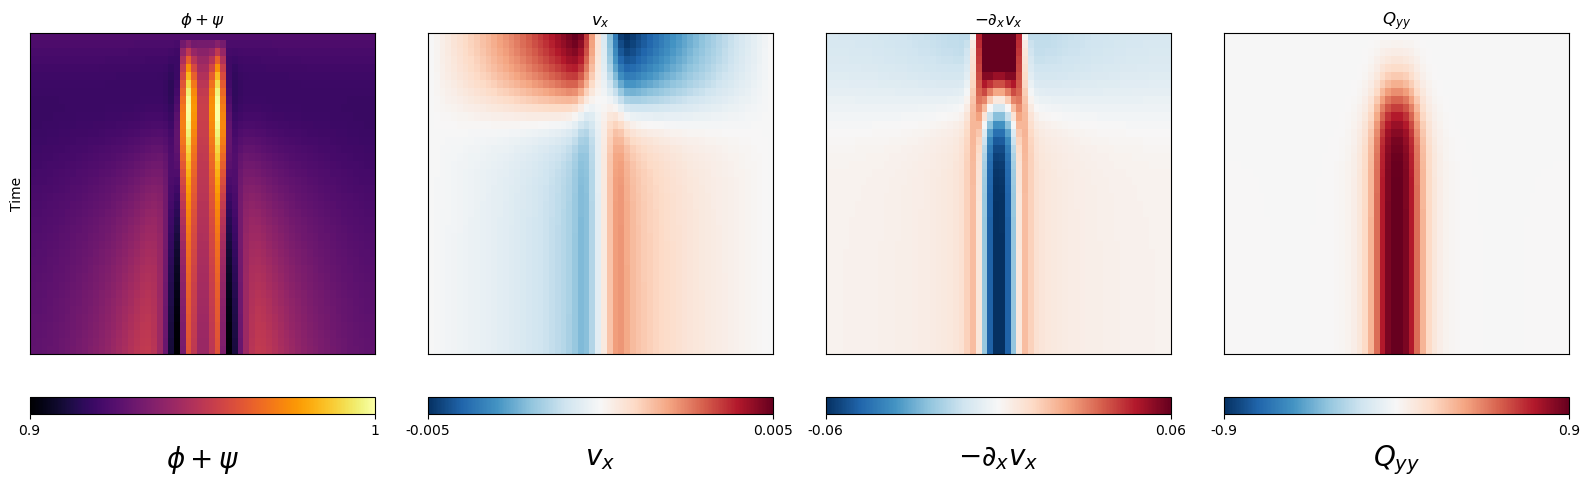

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)
start_index = 0 
end_index = int(20/0.5)
data = sim_results[0][start_index:end_index] 
vx = data[:, 24, :, 2]
dxvx = np.gradient(vx, axis=1)/(1/n_samples)
density = data[:, 24, :, 1] + data[:, 24, :, 0]

fields = [
    (density, r'$\phi + \psi$', 'inferno', np.min(density), np.max(density)),
    (vx, r'$v_x$',  'RdBu_r', np.min(vx), np.max(vx)),
    (- dxvx, r'$ - \partial_x v_x$', 'RdBu_r', -np.max(dxvx), np.max(dxvx)),
    (- data[:, 24, :, -2], r'$Q_{yy}$',
     'RdBu_r', np.min(data[:, 24, :, -2]), - np.min(data[:, 24, :, -2]))
]

for ax, (field, title, cmap, vmin, vmax) in zip(axes, fields):
    im = ax.imshow(field, aspect='auto', interpolation='none',
                   origin='upper', cmap=cmap, extent=(0, 1, T/2, 0), vmin=vmin, vmax=vmax)
    add_cbar(ax, im, vmin, vmax, title)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_ylabel('Time')

plt.tight_layout()
plt.savefig('../figures/caRhoA_kymo.svg', dpi=500)
plt.show()

In [17]:
def plot_frame(n_samples, rho, div_v, vx, vy, nx, ny, Qxx, filename, stride=3):
    X = np.linspace(0, 1, n_samples)
    Y = np.linspace(0, 1, n_samples)
    X, Y = np.meshgrid(X, Y)

    # Plot the contour for rho_vals
    fig, axes = plt.subplots(1, 4, figsize=(17, 5))

    # Density plot
    im0 = axes[0].imshow(rho, aspect='auto', interpolation='none',
                          origin='upper', cmap='inferno', extent=(0, 1, 1, 0))
    add_cbar(axes[0], im0, np.min(rho), np.max(rho), r'$\phi + \psi$')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Velocity plot
    mag = np.sqrt(vx**2+vy**2)
    im2 = axes[1].pcolor(X, Y, mag, cmap='Reds')
    add_cbar(axes[1], im2, np.min(mag), np.max(mag), r'$v$')
    axes[1].quiver(X[2::stride, 2::stride], Y[2::stride, 2::stride],
                   (vx/mag)[2::stride, 2::stride], (vy /
                                                    mag)[2::stride, 2::stride],
                   scale=15,
                   width=0.011, pivot='mid', headwidth=3, headlength=3, headaxislength=3,
                   color='black'
                   )
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Compression rate plot
    max_div_v = np.max(np.abs(div_v))
    im1 = axes[2].pcolor(X, Y, div_v, cmap='RdBu_r', vmin=-max_div_v, vmax=max_div_v)
    add_cbar(axes[2], im1, -max_div_v, max_div_v, r'$\nabla \cdot v$')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    # Nematic order plot
    mag = np.sqrt(nx**2 + ny**2)
    vmax = np.max(np.abs(Qxx))
    vmin = - vmax
    im3 = axes[3].pcolor(X, Y, -Qxx, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    add_cbar(axes[3], im3, vmin, vmax, r'$Q_{yy}$')
    axes[3].quiver(X[2::stride, 2::stride], Y[2::stride, 2::stride],
                   (nx/mag)[2::stride, 2::stride], (ny /
                                                    mag)[2::stride, 2::stride],
                   color='black', scale=20, width=0.010, pivot='mid', headwidth=0, headlength=0, headaxislength=0
                   )
    axes[3].set_xticks([])
    axes[3].set_yticks([])

    plt.tight_layout()
    plt.savefig(filename, dpi=400)
    plt.show()


/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_11063/991783964.py:21: RuntimeWarning: invalid value encountered in divide
  (vx/mag)[2::stride, 2::stride], (vy /


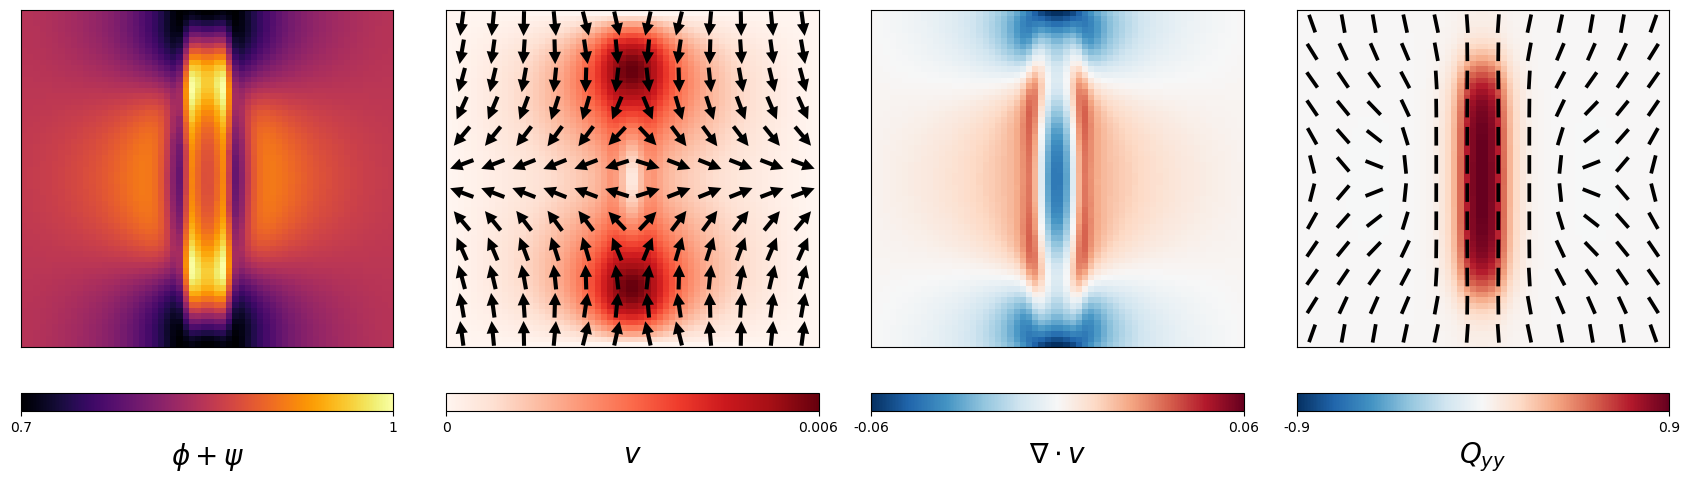

In [68]:
t = -1

for i, data in enumerate(sim_results):
    rho, rho2, vx, vy, Q, q = np.rollaxis(data[t], -1)
    nx, ny = utils.nematic_to_vector(Q, q)

    div_v = np.gradient(vy, axis=0)/(1/n_samples) + \
        np.gradient(vx, axis=1)/(1/n_samples)

    filename = f'../figures/caRhoA_{i+1}.svg'
    plot_frame(n_samples, rho+rho2, -div_v, vx, vy,
            nx, ny, Q, filename=filename, stride=5)

IndexError: index 200 is out of bounds for axis 0 with size 200

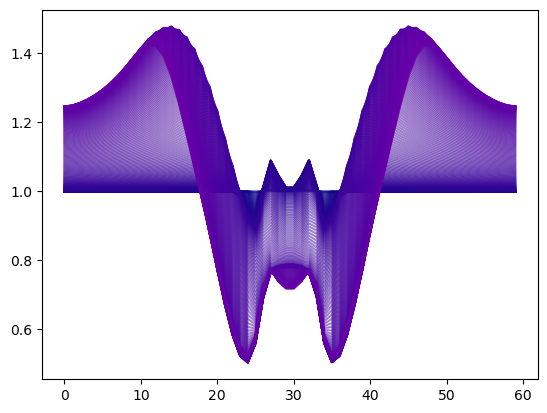

In [116]:
rho2 = data[:, 24, :, 1]
rho1 = data[:, 24, :, 0]
colors = plt.cm.plasma(np.linspace(0, 1, T*10))

fig, ax = plt.subplots()
for i in range(T*10):
    ax.plot(rho2[i]+rho1[i], '-', alpha=0.5, color=colors[i])

sm = plt.cm.ScalarMappable(
    cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=T-1))
sm.set_array([])  # Only needed for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, label='Time step')

plt.title('rho')
plt.show()